In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [16, 8]

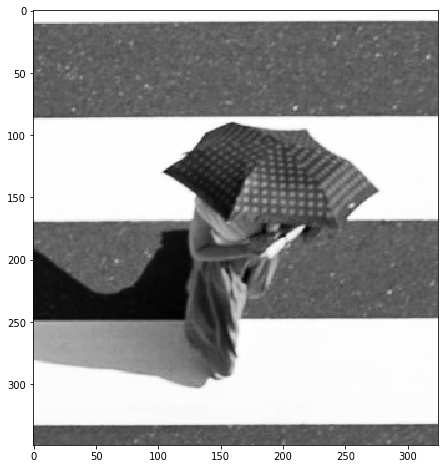

In [3]:
img = cv2.imread('umbrella.jpg',0)
plt.imshow(img,'gray')

In [4]:
def translateImg(img,dx,dy):
    i_index = np.zeros(img.shape)
    j_index = np.zeros(img.shape)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            i_index[i,j] = i
            j_index[i,j] = j

    index_mat = np.zeros((img.shape[0],img.shape[1],3))
    index_mat[:,:,0] = i_index
    index_mat[:,:,1] = j_index
    index_mat[:,:,2] = np.full(img.shape,1)
    index_mat = np.reshape(index_mat,(img.shape[0]*img.shape[1],3))

    trans_mat = np.array([[1,0,0],[0,1,0],[-dy,-dx,1]])
    trans_index = np.reshape(index_mat.dot(trans_mat),(img.shape[0],img.shape[1],3)).astype('int')
    trans_img = np.zeros(img.shape,dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            n_i = trans_index[i,j,0]
            n_j = trans_index[i,j,1]
            if(n_i < 0) or (n_i > img.shape[0]-1):
                trans_img[i,j] = 0
            elif(n_j < 0) or (n_j > img.shape[1]-1):
                trans_img[i,j] = 0
            else:
                trans_img[i,j] = img[n_i,n_j]
    return trans_img

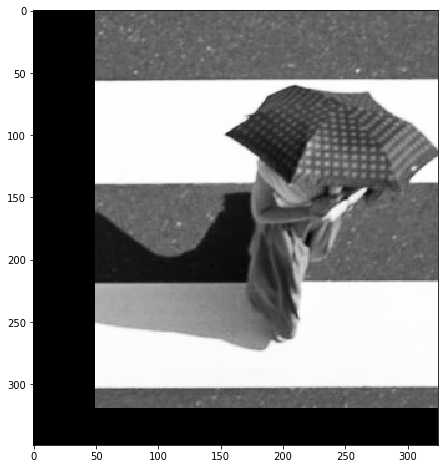

In [5]:
plt.imshow(translateImg(img,50,-30),'gray')

In [6]:
def rotateImg(img, theta, mode):
    w = nw = img.shape[1]
    h =nh = img.shape[0]
    rot_mat = np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]])
    if mode == 'full':
        # calculate image size after rotation
        tl = np.round(np.array([[-h/2,-w/2,1]]).dot(rot_mat)).astype(int)
        tr = np.round(np.array([[-h/2,w/2,1]])).dot(rot_mat).astype(int)
        bl = np.round(np.array([[h/2,-w/2,1]]).dot(rot_mat)).astype(int)
        br = np.round(np.array([[h/2,w/2,1]]).dot(rot_mat)).astype(int)
        nh = np.max([tl[0,0],tr[0,0],bl[0,0],br[0,0]])*2
        nw = np.max([tl[0,1],tr[0,1],bl[0,1],br[0,1]])*2
    elif mode != 'same':
        print('Modes: "full", "Same"')
        return -1
        
    # create matrix indexes of the original image where the center pixel is [0,0] and to the left and up are negative values 
    # ex: [[(-1,-1),(-1,0),(-1,1)],
    #      [(0 ,-1),(0 ,0),(0 ,1)],
    #      [(1 ,-1),(1 ,0),(1 ,1)]]
    i_index = np.zeros((nh,nw))
    j_index = np.zeros((nh,nw))
    for i in range(nh):
        for j in range(nw):
            i_index[i,j] = i-int(nh/2)
            j_index[i,j] = j-int(nw/2)
    index_mat = np.zeros((nh,nw,3))
    index_mat[:,:,0] = i_index
    index_mat[:,:,1] = j_index
    index_mat[:,:,2] = np.full((nh,nw),1)
    index_mat = np.reshape(index_mat,(nw*nh,3))
    
    # create matrix indexes of the rotated image where the center pixel is still [0,0] but other values are rotated 
    rot_index = np.reshape(index_mat.dot(np.linalg.inv(rot_mat)),(nh,nw,3)).astype('int')
    # create the rotated images where rot_img[i,j] = rot_index[i+h/2,j+w/2] (to get back to regular coordinate system)
    rot_img = np.zeros((nh,nw),dtype=int)
    for i in range(nh):
        for j in range(nw):
            n_i = rot_index[i,j,0]+int(h/2)
            n_j = rot_index[i,j,1]+int(w/2)
            if(n_i < 0) or (n_i >h-1):
                rot_img[i,j] = 0
            elif(n_j < 0) or (n_j > w-1):
                rot_img[i,j] = 0
            else:
                rot_img[i,j] = img[n_i,n_j]
    return rot_img

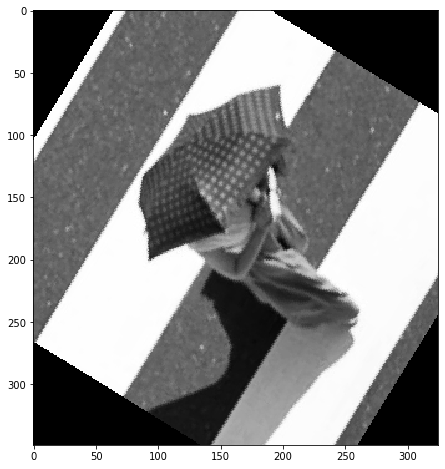

In [7]:
rotated_image = rotateImg(img,45,'same')
plt.imshow(rotated_image,'gray')

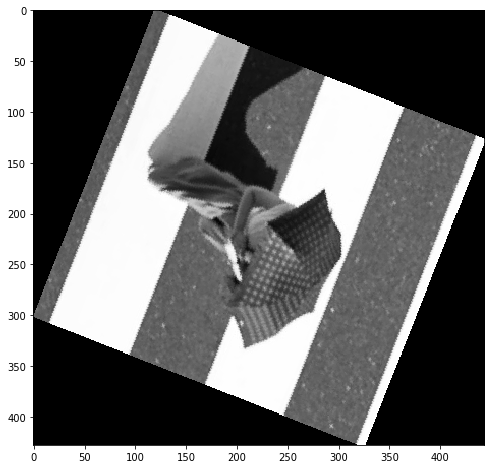

In [8]:
rotated_image = rotateImg(img,130,'full')
plt.imshow(rotated_image,'gray')

In [9]:
def findTranslation(img):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-9-6f09334c743d>, line 2)

In [37]:
img = cv2.imread('umbrella.jpg',0)
img2 = translateImg(img,20,40)
h,w = img.shape[:2]
min_error = error = np.inf
best = (0,0)

# for u in range(-h+1,h,100):
#     for v in range(-w+1,w,100):
for u in range(0,50,10):
    for v in range(0,50,10):
        tl = (np.max([u,0]),np.max([v,0]))
        br = (np.min([h+u-1,h-1]),np.max([w+v-1,w-1]))
        sub_size = (br[0]-tl[0])*(br[1]-tl[1])
        trans = translateImg(img,u,v)
        error = np.sum(((trans[tl[0]:br[0],tl[1]:br[1]]-img2[tl[0]:br[0],tl[1]:br[1]])**2))/sub_size
        if error < min_error:
            min_error = error
            best = (u,v)
print(best)

(20, 40)


# Image Pyramids

In [76]:
# def GaussianPyramid(im:np.ndarray, maxLevels:int, filterSize:int)->(list[np.ndarray],np.ndarray):
def GaussianPyramid(im:np.ndarray, maxLevels:int, filterSize:int):
    pyramids = []
    pyramids.append(im)
    for i in range(maxLevels):
        h,w = pyramids[i].shape[:2]
        temp = cv2.GaussianBlur(pyramids[i],(filterSize,filterSize),0)
        temp = cv2.resize(temp,(int(w/2),int(h/2)))
        pyramids.append(temp)
    return pyramids

# def LaplacianPyramid(im, maxLevels, filterSize)->(list[np.ndarray],np.ndarray)
def LaplacianPyramid(im, maxLevels, filterSize):
    pyramids = []
    gauss_pyr = GaussianPyramid(im,maxLevels,filterSize)
    for i in range(maxLevels-1):
        h,w = gauss_pyr[i].shape[:2]
        temp = cv2.resize(gauss_pyr[i+1],(w,h))
        temp = gauss_pyr[i] - temp
        temp = cv2.resize(temp,(int(w/2),int(h/2)))
        pyramids.append(temp)
    pyramids.append(gauss_pyr[maxLevels-1])
    return pyramids

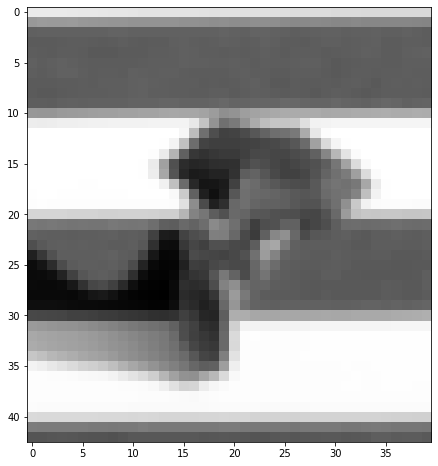

In [77]:
img = cv2.imread('umbrella.jpg',0)
pyr = GaussianPyramid(img,3,5)
plt.imshow(pyr[3],'gray')

In [78]:
img.shape

(349, 325)

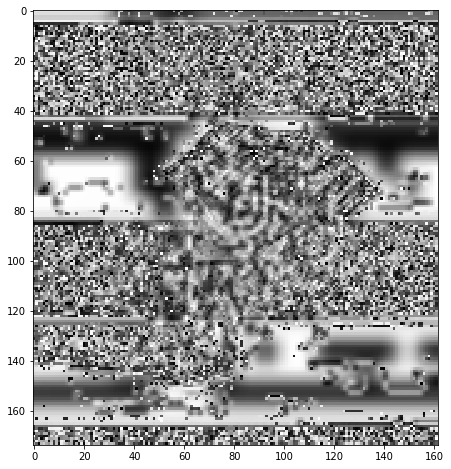

In [152]:
img = cv2.imread('umbrella.jpg',0)
pyr = LaplacianPyramid(img,5,5)
# plt.imshow(pyr[4],'gray')
h,w = img.shape[:2]
og = cv2.resize(pyr[4],(pyr[3].shape[1],pyr[3].shape[0]))+pyr[3]
og = cv2.resize(og,(pyr[2].shape[1],pyr[2].shape[0]))+pyr[2]
og = cv2.resize(og,(pyr[1].shape[1],pyr[1].shape[0]))+pyr[1]
og = cv2.resize(og,(pyr[0].shape[1],pyr[0].shape[0]))+pyr[0]
plt.imshow(og,'gray')

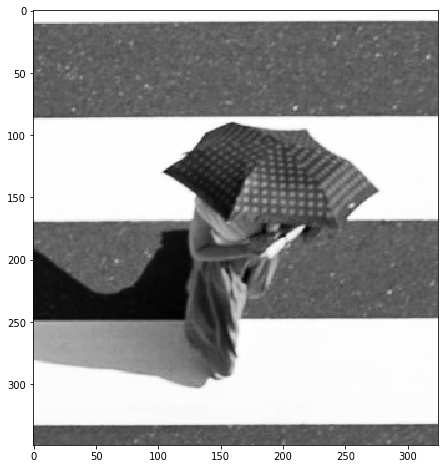

In [129]:
plt.imshow(img,'gray')